In [1]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

pd.set_option('display.max_columns', None)

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## SIR Fundamentals

### Initial Conditions

In [2]:
# Population
N = 1000

# Population distribution at initial conditions
I0, R0 = 4, 0
S0 = N - I0 - R0

### Rate Parameters

In [3]:
# Number of people an infected person comes into contact with per day
contact_rate = 5  
# Probability an infected person infecting someone the contact.
infect_prob = 0.2
# Expected # of people 1 Infected person infects per day
beta = contact_rate * infect_prob

# Number of days an infected person can infect others.
D = 7
# Rate of Recovery / proportion recovering each day
gamma = 1 / D

# Basic Reproduction number
R_naught = beta / gamma

### Flows

In [4]:
def deriv_sir(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * (S/N)
    dIdt = beta * I * (S/N) - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Add Time and Integrate

In [14]:
t = np.linspace(0,150,150)
y0 = S0, I0, R0

sir_time_series = odeint(deriv_sir, y0, t, args = (N, beta, gamma))
sir_ts_rounded = np.round(sir_time_series,0)
sir_ts_rounded

S, I, R = sir_time_series.T

### Explore ranges of rates

In [17]:
cont_rate_range = [2, 5, 8, 10]
D_range = [3, 7, 20]

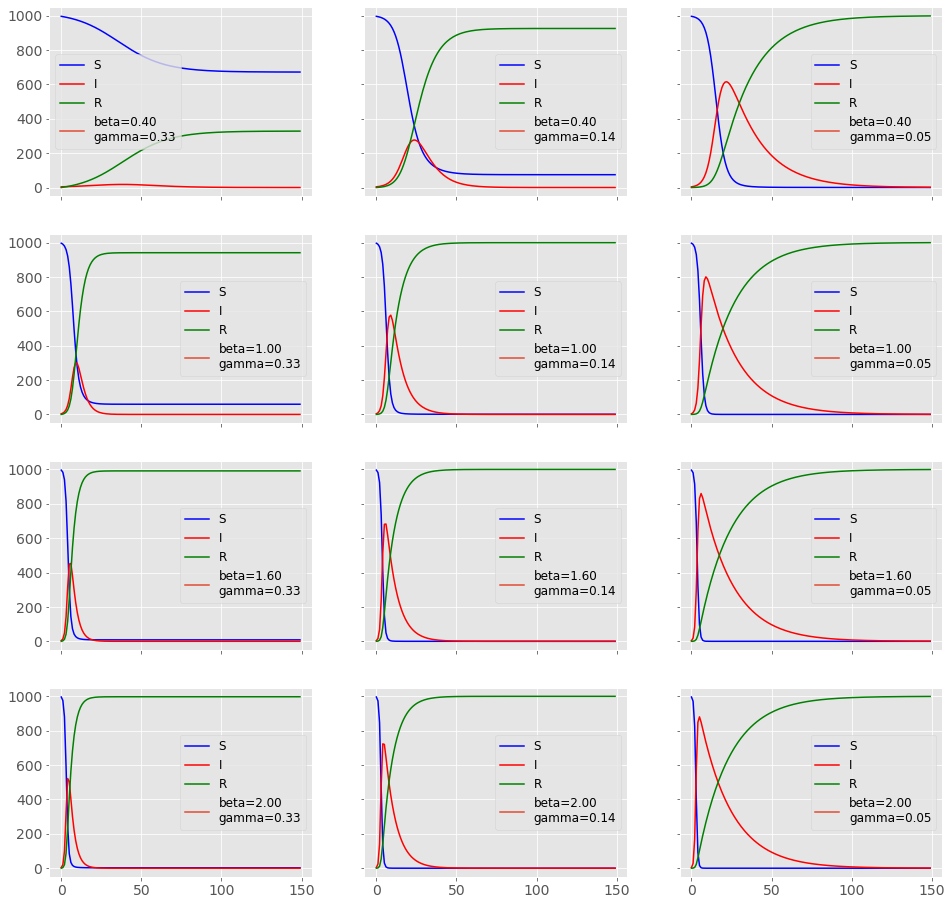

In [18]:
nrows = len(cont_rate_range)
ncols = len(D_range)
infect_prob = 0.2
fig, ax = plt.subplots(nrows, ncols, figsize = (16, 16), sharex = True, sharey=True)

for i in range(nrows):
    for j in range(ncols):
        beta = cont_rate_range[i] * infect_prob
        gamma = 1 / D_range[j]
        sir_time_series = odeint(deriv_sir, y0, t, args = (N, beta, gamma))
        S, I, R = sir_time_series.T
        ax[i, j].plot(S, color = "blue", label='S')
        ax[i, j].plot(I, color = "red", label='I')
        ax[i, j].plot(R, color = "green", label='R')
        ax[i, j].plot([], label=f'beta={beta:.2f}\ngamma={gamma:.2f}')
        ax[i, j].legend(prop={'size':12})
plt.show();  


## USA State Data

In [3]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')

In [4]:
df_usa_rates = pd.read_csv('../data/us_states_covid19_daily.csv')
df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear

In [22]:
df_usa = pd.merge(df_usa_rates, df_usa_pop, how='outer', left_on='state', right_on='ABBR',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['datetime','d_o_y','NAME', 'state', 'POPESTIMATE2019','positiveIncrease', 
                         'positive', 'negativeIncrease', 'negative', 'pending', 'deathIncrease', 
                         'death', 'recovered', 'hospitalizedIncrease','hospitalized',
                         'totalTestResultsIncrease','totalTestResults','posNeg','total']]

df_usa.columns = ['Date','Day of Year','State', 'State Abbr', 'State Pop (2019)','New Positive Cases', 
                  'Cumulative Positive Cases', 'New Negative Cases', 'Cumulative Negative Cases', 'New Pending Cases','New Deaths', 
                  'Cumulative Deaths', 'Cumulative Recovered', 'New Hospitalizations','Cumulative Hospitalizations',
                  'New Total Test Results','Cumulative Total Test Results','Cumulative Positive Test Results','Cumulative Negative Test Results']
# df_usa.columns = ['datetime','d_o_y','state_name', 'state_id', 'state_pop_2019','positive_daily_incr', 
#                   'positive_cum', 'negative_daily_incr', 'negative_cum', 'pending_daily','death_daily_incr', 
#                   'death_cum', 'recovered_cum', 'hospitalized_daily_incr','hospitalized_cum',
#                   'total_test_results_daily_incr','total_test_results_cum','test_pos_neg_cum','total_tests_cum']

In [23]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14

# states = ['NY', 'FL', 'CA']
states = ['NY']
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(states)]
df2['Rolling-{num_days}mean'] = df2['positive_daily_incr'].rolling(window=num_days, center = True).mean()

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


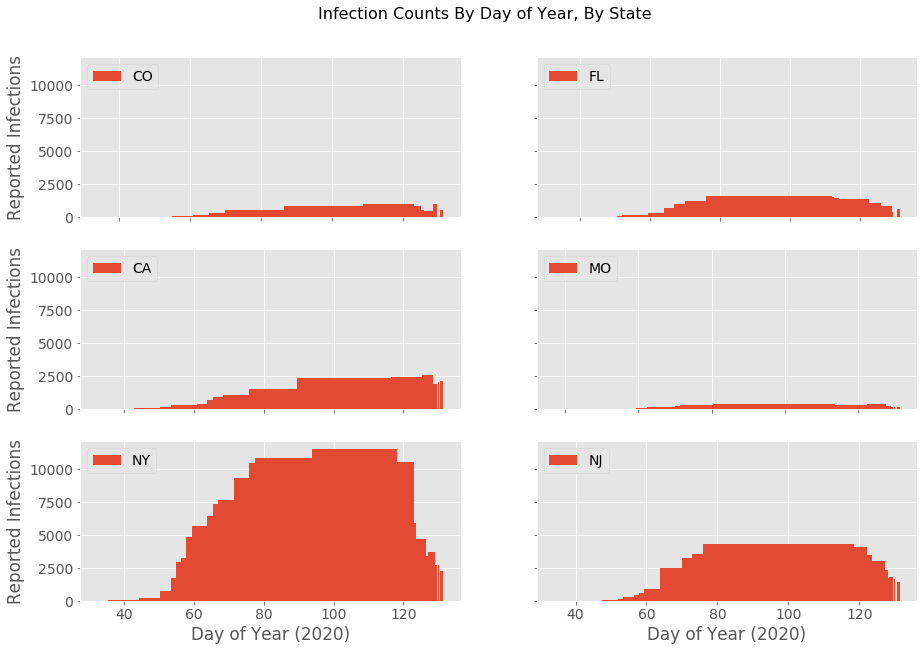

In [25]:
states = ['CO', 'FL', 'CA', 'MO', 'NY', 'NJ']
fig, axes = plt.subplots(3,2,figsize = (15,10), sharey=True)
for ax, state in zip(axes.flat, states):
    df2 = df_usa[df_usa['state_id']==state]
    ax.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}")
    ax.legend(loc='upper left')
    ax.set_xlabel('Day of Year (2020)') 
    ax.set_ylabel('Reported Infections') 
    ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();

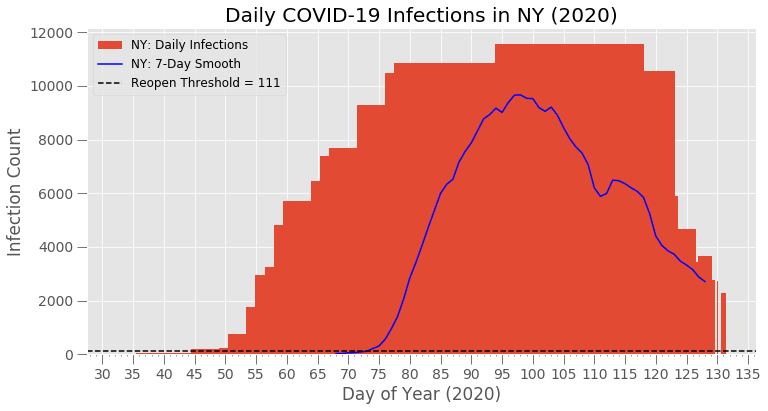

In [24]:
fig, ax = plt.subplots(figsize = (12,6))
for state in states:
    plt.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")
# ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();

## World Data

In [4]:
# df_world = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_world = pd.read_csv('../data/owid-covid-data.csv')
df_world['d_o_y'] = pd.DatetimeIndex(df_world['date']).dayofyear
df_world.drop(df_world[df_world['date']=='2019-12-31'].index, axis=0, inplace=True)

In [5]:
df_world.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,73
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,80
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,84
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,85
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,86


In [6]:
df_world[df_world.new_cases < 0]

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y
4555,ECU,Ecuador,2020-05-07,29420,-2461,1618,49,1667.511,-139.488,91.707,2.777,44373.0,1503.0,2.515,0.085,samples tested,17643060.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.50,128
4557,ECU,Ecuador,2020-05-09,28818,-1480,1704,50,1633.390,-83.886,96.582,2.834,NaN,NaN,NaN,NaN,NaN,17643060.0,66.939,28.1,7.104,4.458,10581.936,3.6,140.448,5.55,2.0,12.3,80.635,1.50,130
4866,ESP,Spain,2020-04-19,188578,-1430,20453,410,4033.341,-30.585,437.453,8.769,NaN,NaN,NaN,NaN,NaN,46754783.0,93.105,45.5,19.436,13.799,34272.360,1.0,99.403,7.17,27.4,31.4,NaN,2.97,110
9574,LTU,Lithuania,2020-04-29,1344,-105,44,3,493.702,-38.570,16.163,1.102,118201.0,6392.0,43.420,2.348,samples tested,2722291.0,45.135,43.5,19.002,13.778,29524.265,0.7,342.989,3.67,21.3,38.0,NaN,6.56,120
12717,PRT,Portugal,2020-05-03,25190,-161,1023,16,2470.405,-15.789,100.327,1.569,458702.0,8458.0,44.985,0.829,samples tested,10196707.0,112.371,46.2,21.502,14.924,27936.896,0.5,127.842,9.85,16.3,30.0,NaN,3.39,124
13973,SMR,San Marino,2020-05-11,628,-9,41,0,18504.331,-265.189,1208.085,0.000,NaN,NaN,NaN,NaN,NaN,33938.0,556.667,NaN,NaN,NaN,56861.470,NaN,NaN,5.64,NaN,NaN,NaN,3.80,132
16591,NaN,International,2020-03-10,696,-9,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70


In [7]:
df_world[(df_world['date']=='2019-12-31') & (df_world['total_cases']!=0)]

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,d_o_y


## USA State Data

In [16]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')
df_usa_pop.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,ABBR,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS
0,10,0,0,0,United States,US,328239523,255200373,77.7
1,40,3,6,1,Alabama,AL,4903185,3814879,77.8
2,40,4,9,2,Alaska,AK,731545,551562,75.4
3,40,4,8,4,Arizona,AZ,7278717,5638481,77.5
4,40,3,7,5,Arkansas,AR,3017804,2317649,76.8


In [17]:
df_usa_rates = pd.read_csv('../data/us_states_covid19_daily.csv')
df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear

In [18]:
pwd

'/home/asa/galvanize/repos/covid-forecasting/notebooks'

In [19]:
df_usa_rates.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,27364,27364,2,0.0,0.0,914.0,1.0,915.0,2020-05-10,131
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0,2020-05-10,131
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,65528,65528,5,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,83,83,60,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0,2020-05-10,131


In [20]:
df_usa = pd.merge(df_usa_rates, df_usa_pop, how='outer', left_on='state', right_on='ABBR',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)[['datetime','d_o_y','NAME', 'state', 'POPESTIMATE2019','positiveIncrease', 
                         'positive', 'negativeIncrease', 'negative', 'pending', 'deathIncrease', 'death', 'recovered', 
                         'hospitalizedIncrease','hospitalized','totalTestResultsIncrease',
                         'totalTestResults','posNeg','total']]
df_usa.columns = ['datetime','d_o_y','state_name', 'state_id', 'state_pop_2019','positive_daily_incr', 
                  'positive_cum', 'negative_daily_incr', 'negative_cum', 'pending_daily','death_daily_incr', 
                  'death_cum', 'recovered_cum', 'hospitalized_daily_incr','hospitalized_cum',
                  'total_test_results_daily_incr','total_test_results_cum','test_pos_neg_cum','total_tests_cum']
df_usa.head(10)

,datetime,d_o_y,state_name,state_id,state_pop_2019,positive_daily_incr,positive_cum,negative_daily_incr,negative_cum,pending_daily,death_daily_incr,death_cum,recovered_cum,hospitalized_daily_incr,hospitalized_cum,total_test_results_daily_incr,total_test_results_cum,test_pos_neg_cum,total_tests_cum
0,2020-05-10,131.0,Alaska,AK,731545.0,1.0,379.0,914.0,26985.0,NaN,0.0,10.0,324.0,0.0,NaN,915.0,27364.0,27364.0,27364.0
1,2020-05-09,130.0,Alaska,AK,731545.0,1.0,378.0,975.0,26071.0,NaN,0.0,10.0,318.0,0.0,NaN,976.0,26449.0,26449.0,26449.0
2,2020-05-08,129.0,Alaska,AK,731545.0,3.0,377.0,1129.0,25096.0,NaN,0.0,10.0,305.0,0.0,NaN,1132.0,25473.0,25473.0,25473.0
3,2020-05-07,128.0,Alaska,AK,731545.0,2.0,374.0,684.0,23967.0,NaN,0.0,10.0,291.0,0.0,NaN,686.0,24341.0,24341.0,24341.0
4,2020-05-06,127.0,Alaska,AK,731545.0,1.0,372.0,962.0,23283.0,NaN,1.0,10.0,284.0,0.0,NaN,963.0,23655.0,23655.0,23655.0
5,2020-05-05,126.0,Alaska,AK,731545.0,1.0,371.0,968.0,22321.0,NaN,0.0,9.0,277.0,0.0,NaN,969.0,22692.0,22692.0,22692.0
6,2020-05-04,125.0,Alaska,AK,731545.0,2.0,370.0,143.0,21353.0,NaN,0.0,9.0,263.0,0.0,NaN,145.0,21723.0,21723.0,21723.0
7,2020-05-03,124.0,Alaska,AK,731545.0,3.0,368.0,176.0,21210.0,NaN,0.0,9.0,262.0,0.0,NaN,179.0,21578.0,21578.0,21578.0
8,2020-05-02,123.0,Alaska,AK,731545.0,1.0,365.0,1073.0,21034.0,NaN,0.0,9.0,261.0,0.0,NaN,1074.0,21399.0,21399.0,21399.0
9,2020-05-01,122.0,Alaska,AK,731545.0,9.0,364.0,1197.0,19961.0,NaN,0.0,9.0,254.0,0.0,NaN,1206.0,20325.0,20325.0,20325.0


In [28]:
pwd

'/home/asa/galvanize/repos/covid-forecasting/notebooks'

In [53]:
states_str = "-".join(states)
states_str
len(states) // 2

3

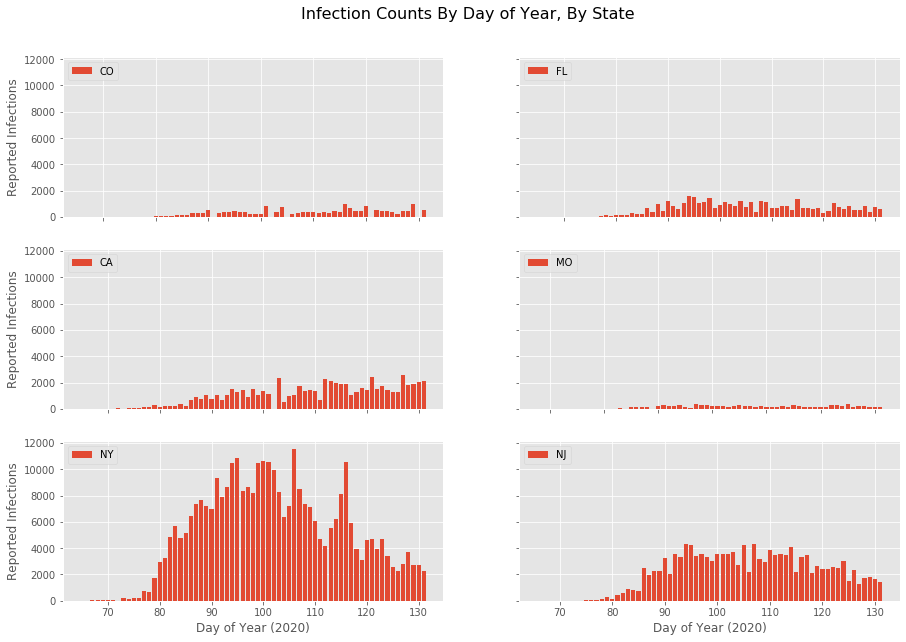

In [48]:
states = ['CO', 'FL', 'CA', 'MO', 'NY', 'NJ']
fig, axes = plt.subplots(3,2,figsize = (15,10), sharey=True)
for ax, state in zip(axes.flat, states):
    df2 = df_usa[df_usa['state_id']==state]
    ax.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}")
    ax.legend(loc='upper left')
    ax.set_xlabel('Day of Year (2020)') 
    ax.set_ylabel('Reported Infections') 
    ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();
fig.savefig("../images/infection_counts_by_doy.png", dpi=125)

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


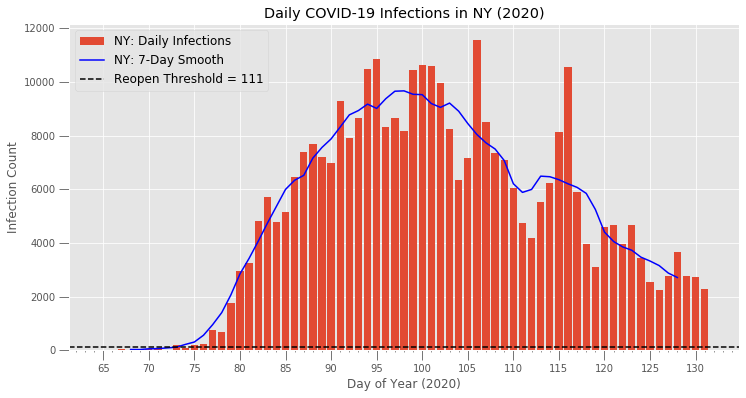

In [24]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14

# states = ['NY', 'FL', 'CA']
states = ['NY']
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(states)]
df2['Rolling-{num_days}mean'] = df2['positive_daily_incr'].rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
for state in states:
    plt.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")
# ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();
fig.savefig(f"../images/infection_counts_by_doy_smoothed_thresh-NY.png", dpi=250)

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


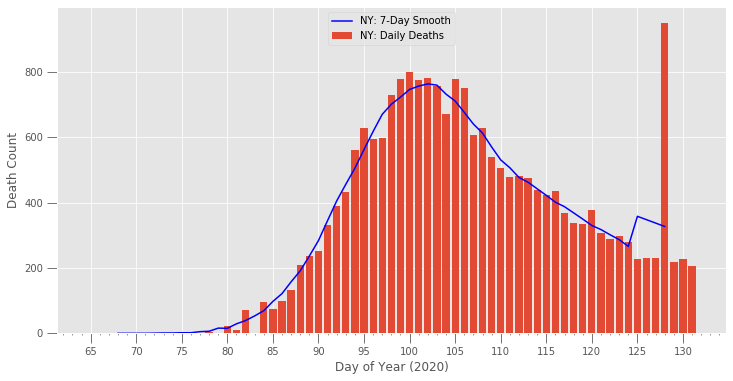

In [11]:
# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10/100000/14

# states = ['NY', 'FL', 'CA']
states = ['NY']
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = reopen_thresh * states_pop
num_days = 7
df2 = df_usa[df_usa['state_id'].isin(states)]
df2['Rolling-{num_days}mean'] = df2['death_daily_incr'].rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
for state in states:
    plt.bar(df2.d_o_y, df2['death_daily_incr'], label = f"{state}: Daily Deaths")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
# ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Death Count')
plt.legend()
plt.show();

In [22]:
reopen_thresh = 10./100000/14

states = ['NY', 'FL', 'CA']
# states = ['NY']
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
state_reopen_thresh


[111, 124, 219]

In [128]:
states_pop

[15425262]

In [213]:
N = 1000
beta = 1.0 # infected person infects 1 other person per day
D = 4.0 # infections last 4 days
gamma = 1.0 / D
delta = 1.0 / 3 # incubation period of 3 days

S0, E0, I0, R0 = N-1, 1, 0, 0

In [214]:
def deriv_seir(y, t, N, beta, gamma, delta):
    S, E, I, R = y

    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [215]:
t = np.linspace(50,150,100)
# Initial conditions vector
y0 = S0, E0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

In [216]:
def plotseir(t, S, E, I, R, R0=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population Count')
    plt.title(f'SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();
    f.savefig(f"../images/generic_seir_trends.png", dpi=250)

    if R0 is not None:
        f = plt.figure(figsize=(12,4))
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show();
    

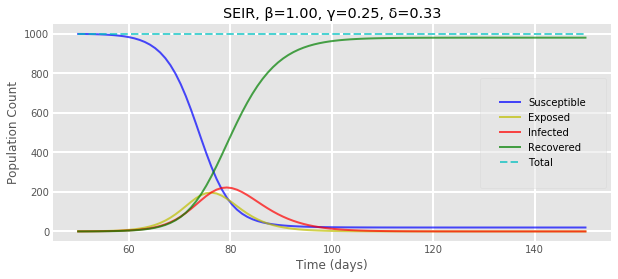

In [217]:
plotseir(t, S, E, I, R)

In [177]:
I[np.argmax(I)]

222.21622601770713

In [181]:
print(f'22% of NY pop is {states_pop[0] * 0.222216:.0f}')

22% of NY pop is 3427740


In [222]:
N = states_pop[0]
print(N)
beta = .999 # infected person infects 1 other person per day
D = 1.18 # infections last 4 days
gamma = 1.0 / D
delta = 1.0 / .05 # incubation period of 3 days

E0 = 100
S0, I0, R0 = N-E0, 0, 0

15425262


In [223]:
t = np.linspace(50,150,100)
# Initial conditions vector
y0 = S0, E0, I0, R0
print(y0)
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

(15425162, 100, 0, 0)


In [186]:
I[np.argmax(I)]

111.16413249890189

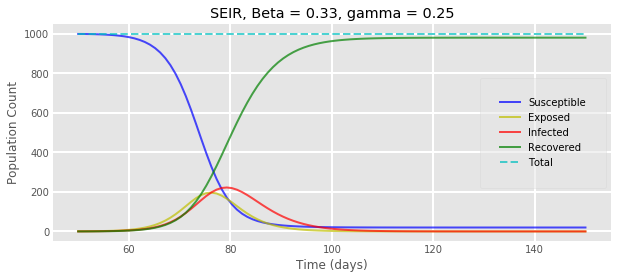

In [196]:
plotseir(t, S, E, I, R)

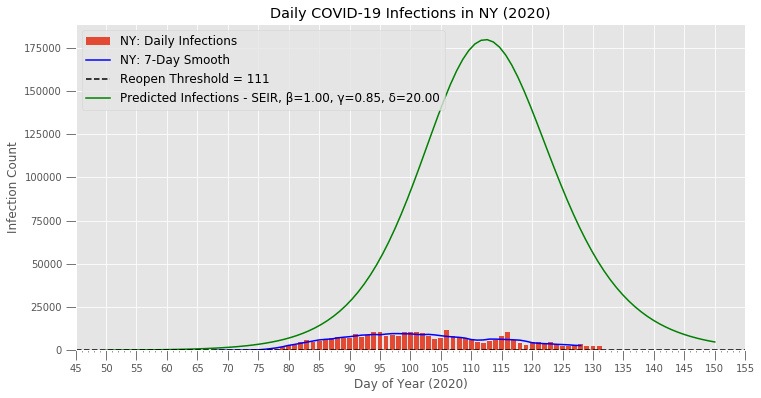

In [224]:
fig, ax = plt.subplots(figsize = (12,6))
for state in states:
    plt.bar(df2.d_o_y, df2['positive_daily_incr'], label = f"{state}: Daily Infections")
    plt.plot(df2.d_o_y, df2['Rolling-{num_days}mean'], label = f"{state}: {num_days}-Day Smooth", color='blue')
    plt.plot(t, I, label = f'Predicted Infections - SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}', color = 'green')
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", label = f"Reopen Threshold = {state_reopen_thresh[0]}")
# ax.set_yscale('log')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
# ax.set_yscale('log')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();
fig.savefig('../images/seir_fit_to_NY_infections-01.png', dpi=250)

In [ ]:
def deriv_sir(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [ ]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [33]:
# mask = [df_usa_pop['ABBR'].isin(states)]
states_pop = df_usa_pop['POPEST18PLUS2019'][df_usa_pop.loc[df_usa_pop['ABBR'] == 'NY'].index]
print(states_pop)
type(states_pop)

33    15425262
Name: POPEST18PLUS2019, dtype: int64


pandas.core.series.Series

In [103]:
N = [df_usa_pop['ABBR'].isin(states)]
# N

In [101]:
# N = df_usa_pop['POPESTIMATE2019'].loc([df_usa_pop['NAME'].isin(states)])
# print(N)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 5, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160) 

NameError: name 'N' is not defined

In [ ]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,100000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

In [ ]:
def plotsird(t, S, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
    plt.show();

In [12]:
pd.unique(df_world['iso_code'])

array(['ABW', 'AFG', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM',
       'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA',
       'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL',
       'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL',
       'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI',
       'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK',
       'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH',
       'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'GAB', 'GBR', 'GEO', 'GGY',
       'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL',
       'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM',
       'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KNA', 'KOR',
       'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU',
       'LUX', 'LVA', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX', 'MKD',
       'MLI', 'MLT',

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


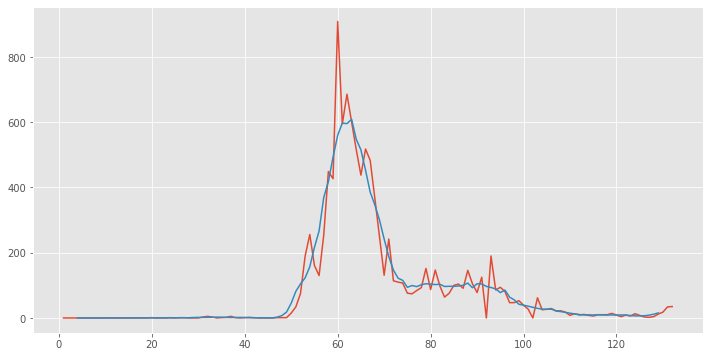

In [8]:
iso_code = 'KOR'
pop_germany = 83750000
num_days = 7
df3 = df_world[df_world['iso_code']==iso_code]
df3['Rolling-{num_days}mean'] = df3.new_cases.rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.d_o_y, df3.new_cases)
plt.plot(df3.d_o_y, df3['Rolling-{num_days}mean'])
# ax.set_yscale('log')
plt.show();

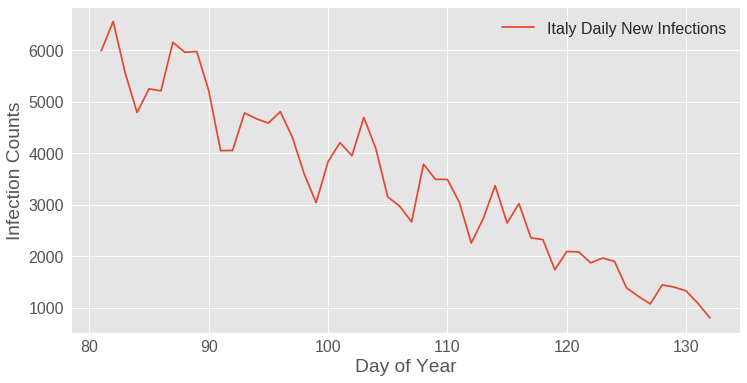

In [84]:
weekly_italy = df_world[ (df_world['iso_code']=='ITA') & ( df_world.d_o_y > 80)]
# weekly_italy['Rolling-{num_days}mean'] = weekly_italy.new_cases.rolling(window=num_days, center = True).mean()
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(weekly_italy.d_o_y, weekly_italy.new_cases, label = 'Italy Daily New Infections')
# plt.plot(weekly_italy.d_o_y, weekly_italy['Rolling-{num_days}mean'], color='r')
# ax.set_yscale('log')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Infection Counts')
ax.axes.tick_params('both', labelsize='medium')
plt.legend(fontsize='medium')
plt.show();

In [93]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)

In [87]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

In [88]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [89]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

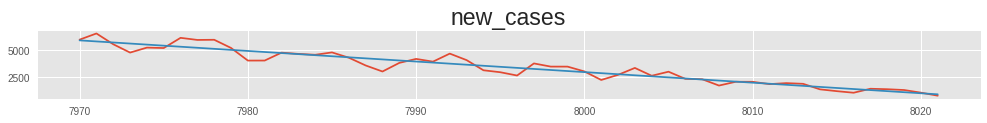

In [94]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'new_cases', weekly_italy['new_cases'])
plt.tight_layout()

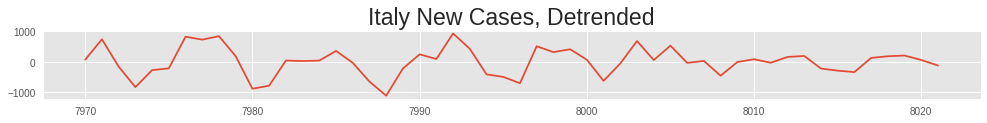

In [95]:
italy_series = weekly_italy['new_cases']
italy_linear_trend = fit_linear_trend(italy_series)
italy_series_detrended = italy_series - italy_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(italy_series_detrended.index, italy_series_detrended)
ax.set_title("Italy New Cases, Detrended")
plt.tight_layout()

In [96]:
def create_day_of_week_dummies(series):
    week = weekly_italy['date'].dt.dayofweek
    return pd.get_dummies(week).iloc[:, :6]

In [100]:
def fit_seasonal_trend(series):
    dummies = create_day_of_week_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [101]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, seasons_average_trend)

AttributeError: Can only use .dt accessor with datetimelike values

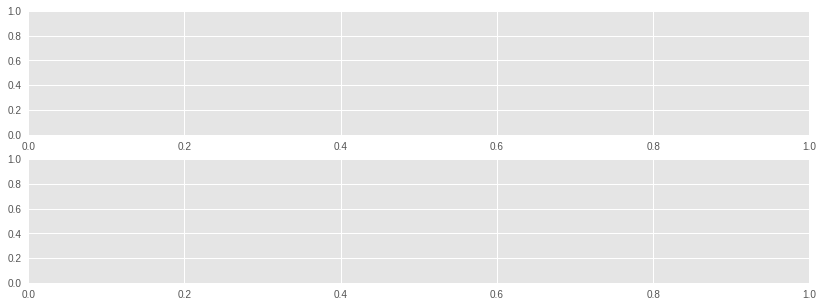

In [102]:
fig, axs = plt.subplots(2, figsize=(14, 5))

plot_seasonal_trend(axs[0], 'Italy', weekly_italy['new_cases'])
plt.tight_layout()

In [68]:
plt.style.available

['seaborn',
 'bmh',
 'seaborn-dark',
 'seaborn-talk',
 'seaborn-deep',
 'grayscale',
 'tableau-colorblind10',
 'seaborn-darkgrid',
 'seaborn-muted',
 'dark_background',
 'seaborn-poster',
 'seaborn-paper',
 'fast',
 'seaborn-dark-palette',
 'seaborn-white',
 'seaborn-colorblind',
 'fivethirtyeight',
 'classic',
 'Solarize_Light2',
 'seaborn-bright',
 'seaborn-ticks',
 'seaborn-pastel',
 '_classic_test',
 'seaborn-notebook',
 'seaborn-whitegrid',
 'ggplot']

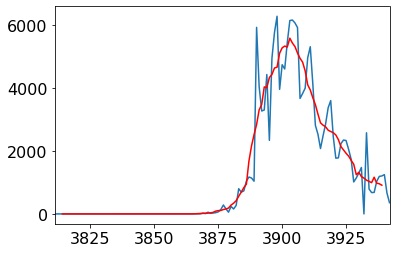

In [42]:
df3.new_cases.plot()
rolling_mean.plot(color='red')
plt.show()

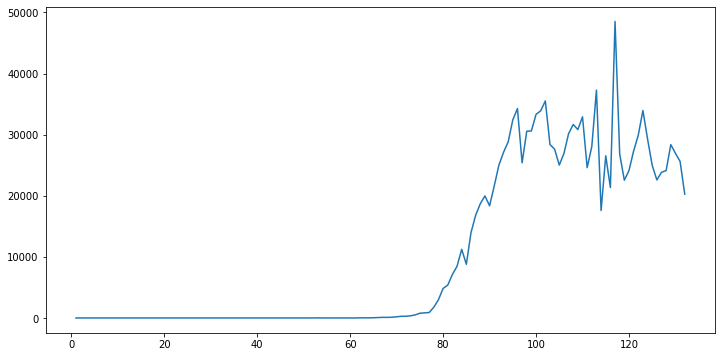

In [84]:
iso_code = 'USA'
df3 = df_world[df_world['iso_code']==iso_code]
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.d_o_y, df3.new_cases)

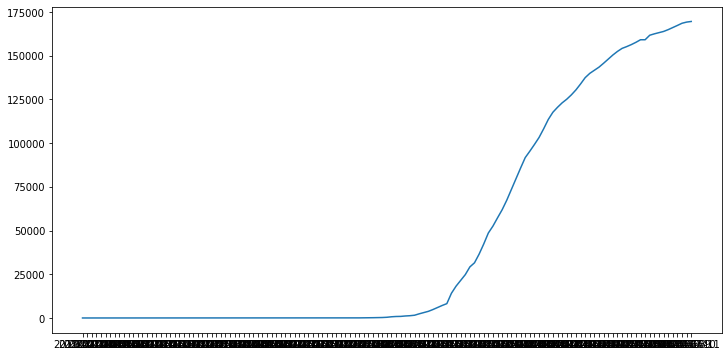

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.date, df3.total_cases)

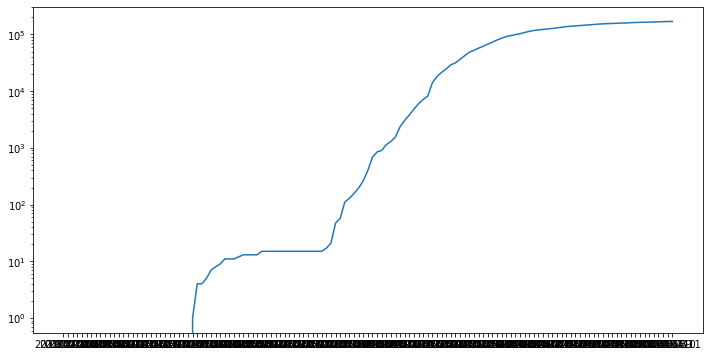

In [25]:
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(df3.date, df3.total_cases)
ax.set_yscale('log')

In [98]:
countries_list = ['China', 'South Korea', 'Italy', 'Iran', 'Spain', 'Germany', 'France', 
                  'United Kingdom', 'Switzerland',  'United States', 'Russia']

In [ ]:
df_world[(df_world['date']=='2020-05-11') & df_world['location']

In [75]:
import os
from operator import itemgetter
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# constants
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
colors = {
  'very_light_gray': '#ececec',
  'light_gray': '#b6b6b6',
  'medium_gray': '#929292',
  'very_dark_gray': '#414141',
  'orange': '#ff6f00',
  'light_blue': '#79c3ff',
  'light_purple': '#d88aff',
  'light_green': '#b4ec70',
  'light_yellow': '#fff27e',
  'light_red': '#ff7482',
  'light_cyan': '#84ffff',
    'black' : '#000000'
}
start_date = np.datetime64('2020-01-22')
all_dates = [start_date + np.timedelta64(x, 'D') for x in range(0, 161)]

In [76]:
def convert_to_ts (data, country):
  df = data[data['location'] == country].groupby(['date'], as_index=False)['total_cases'].sum()
  df.columns = ['date', 'count']
  df['date'] = df['date'].astype('datetime64[ns]')
  return df

data = pd.read_csv('../data/owid-covid-data.csv')
dat = [
  { 'name': 'China', 'color': 'light_gray' },
  { 'name': 'South Korea', 'color': 'medium_gray' },
  { 'name': 'Italy', 'color': 'very_dark_gray' },
  { 'name': 'Iran', 'color': 'light_blue' },
  { 'name': 'Spain', 'color': 'light_purple' },
  { 'name': 'Germany', 'color': 'light_green' },
  { 'name': 'France', 'color': 'light_yellow' },
  { 'name': 'United Kingdom', 'color': 'light_red' },
  { 'name': 'Switzerland', 'color': 'light_cyan' },
  { 'name': 'United States', 'color': 'orange' },
  { 'name': 'Russia', 'color': 'black' }
]
countries = { d['name']: convert_to_ts(data, d['name']) for d in dat}

In [77]:
countries

{'China':           date  count
 0   2019-12-31     27
 1   2020-01-01     27
 2   2020-01-02     27
 3   2020-01-03     44
 4   2020-01-04     44
 5   2020-01-05     59
 6   2020-01-06     59
 7   2020-01-07     59
 8   2020-01-08     59
 9   2020-01-09     59
 10  2020-01-10     59
 11  2020-01-11     59
 12  2020-01-12     59
 13  2020-01-13     59
 14  2020-01-14     59
 15  2020-01-15     59
 16  2020-01-16     59
 17  2020-01-17     63
 18  2020-01-18     80
 19  2020-01-19    216
 20  2020-01-20    235
 21  2020-01-21    386
 22  2020-01-22    526
 23  2020-01-23    623
 24  2020-01-24    882
 25  2020-01-25   1323
 26  2020-01-26   1988
 27  2020-01-27   2775
 28  2020-01-28   4528
 29  2020-01-29   5994
 30  2020-01-30   7734
 31  2020-01-31   9714
 32  2020-02-01  11809
 33  2020-02-02  14399
 34  2020-02-03  17211
 35  2020-02-04  20448
 36  2020-02-05  24320
 37  2020-02-06  28047
 38  2020-02-07  31207
 39  2020-02-08  34625
 40  2020-02-09  37232
 41  2020-02-10  40206
 4

In [78]:
pd.DataFrame(
  map(lambda obj: [obj[0], f'{obj[1]["count"].max():,.0f}'], countries.items()),
  columns=['Country', 'Max infected']
)

,Country,Max infected
0,China,"84,010"
1,South Korea,"10,909"
2,Italy,"219,070"
3,Iran,"107,603"
4,Spain,"224,390"
5,Germany,"169,575"
6,France,"139,063"
7,United Kingdom,"219,183"
8,Switzerland,"30,222"
9,United States,"1,329,799"


In [79]:
def comparison_to_china_penalty (df, offset):
  china_counts = countries['China']['count'].to_numpy()
  counts = df['count'].to_numpy()
  residuals = []
  for i in range(0, 14):
    if i + offset < len(counts):
      residuals.append(china_counts[i] - counts[i + offset])
    else:
      residuals.append(0)
  return np.power(residuals, 2).sum()

def find_optimal_offset (df):
  penalties = []
  for offset in range(len(df)):
    penalties.append(comparison_to_china_penalty(df, offset))
  return np.argmin(penalties)

for d in dat:
  d['offset'] = find_optimal_offset(countries[d['name']])
dat.sort(key=lambda x: x['offset'])

In [80]:
dat

[{'name': 'China', 'color': 'light_gray', 'offset': 0},
 {'name': 'South Korea', 'color': 'medium_gray', 'offset': 38},
 {'name': 'Italy', 'color': 'very_dark_gray', 'offset': 41},
 {'name': 'Iran', 'color': 'light_blue', 'offset': 44},
 {'name': 'Germany', 'color': 'light_green', 'offset': 47},
 {'name': 'France', 'color': 'light_yellow', 'offset': 48},
 {'name': 'United States', 'color': 'orange', 'offset': 49},
 {'name': 'Spain', 'color': 'light_purple', 'offset': 50},
 {'name': 'United Kingdom', 'color': 'light_red', 'offset': 52},
 {'name': 'Switzerland', 'color': 'light_cyan', 'offset': 53},
 {'name': 'Russia', 'color': 'black', 'offset': 64}]

In [81]:
pd.DataFrame(dat, columns=['name', 'offset'])

,name,offset
0,China,0
1,South Korea,38
2,Italy,41
3,Iran,44
4,Germany,47
5,France,48
6,United States,49
7,Spain,50
8,United Kingdom,52
9,Switzerland,53


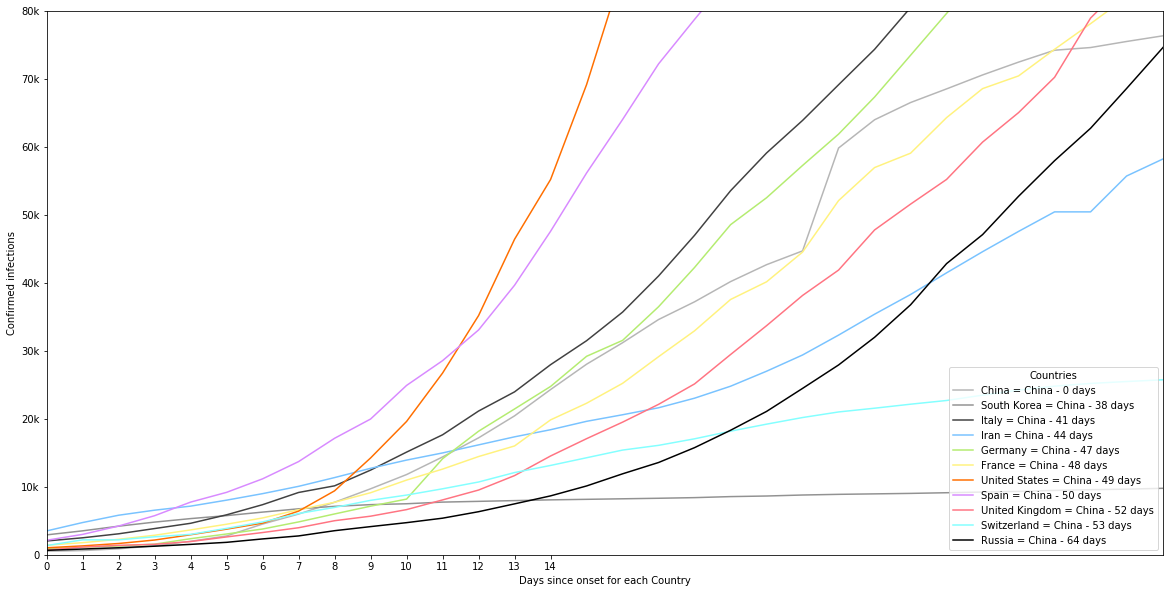

In [82]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for d in dat:
  country_name, offset, color_key = itemgetter('name', 'offset', 'color')(d)
  country = countries[country_name]
  ax.plot(
    country['date'] - np.timedelta64(offset, 'D'),
    country['count'],
    label=f'{country_name} = China - {offset} days',
    color=colors[color_key]
  )

plt.xlim((np.datetime64('2020-01-22'), np.datetime64('2020-02-22')))
plt.xticks([np.datetime64('2020-01-22') + np.timedelta64(d, 'D') for d in range(0, 15)])
ax.set_xticklabels(range(0, 15))
plt.xlabel('Days since onset for each Country')

plt.ylim((0, 80000))
ax.set_yticklabels(['0' if x == 0 else '{:.0f}k'.format(int(x) / 1000) for x in ax.get_yticks().tolist()])
plt.ylabel('Confirmed infections')

plt.legend(title='Countries', loc='lower right')

plt.show();

In [83]:
def sigmoid (x, A, slope, offset):
  return A / (1 + np.exp ((x - (offset + 17.75)) / slope))

def fit_to_sigmoid (df, offset, all_dates):
  dates = (df['date'] - start_date) / np.timedelta64(1, 'D')
  p, _ = curve_fit(
    lambda x, A, slope: sigmoid(x, A, slope, offset),
    dates,
    df['count'],
    p0=[80000, -5],
    bounds=(
      [-np.inf, -np.inf],
      [np.inf, -0.01]
    ),
    maxfev=5000,
  )
  return sigmoid((all_dates - start_date) / np.timedelta64(1, 'D'), *p, offset), p

for d in dat:
  country_name, offset, color_key = itemgetter('name', 'offset', 'color')(d)
  country = countries[country_name]
  fit, p = fit_to_sigmoid(country, offset, all_dates)
  d['fit'] = fit
  d['p'] = p

In [84]:
dat

[{'name': 'China',
  'color': 'light_gray',
  'offset': 0,
  'fit': array([ 1699.44275111,  2101.26093987,  2595.0174159 ,  3200.15359016,
          3939.40664307,  4838.95206965,  5928.31635639,  7239.92900421,
          8808.15499971, 10667.63734637, 12850.80398326, 15384.47901616,
         18285.70689525, 21557.15440221, 25182.76434147, 29124.60606045,
         33321.96223256, 37693.47118784, 42142.56135853, 46565.58896513,
         50861.30642415, 54939.87481885, 58729.77760287, 62181.62802391,
         65268.70965942, 67984.82028812, 70340.39400639, 72357.92552886,
         74067.51881735, 75503.07708155, 76699.36095444, 77689.92780439,
         78505.84011384, 79174.97889207, 79721.79433845, 80167.34778653,
         80529.53022212, 80823.37387892, 81061.40006081, 81253.96703378,
         81409.59684211, 81535.27019419, 81636.68524975, 81718.48023432,
         81784.42212227, 81837.56477985, 81880.3803771 , 81914.86786167,
         81942.64203271, 81965.00638491, 81983.01248702, 8

In [85]:
china_slope = dat[0]['p'][1]
growth_rate_relative_to_china = lambda p: china_slope/p[1]

table_data = []
for d in dat:
  country_name, offset, p = itemgetter('name', 'offset', 'p')(d)
  # name, days behind china, relative growth rate, max infected
  table_data.append([
    country_name, 
    '' if country_name == 'China' else f'{offset}',
    f'{growth_rate_relative_to_china(p):.1f}',
    f'{p[0]:,.0f}'
  ])

pd.DataFrame(table_data, columns=['Country', 'Days behind China', 
                                  'Growth rate relative to China', 'Estimated max infected'])

,Country,Days behind China,Growth rate relative to China,Estimated max infected
0,China,,1.0,"82,057"
1,South Korea,38,0.3,"12,473"
2,Italy,41,0.6,"172,706"
3,Iran,44,0.5,"83,227"
4,Germany,47,0.7,"140,690"
5,France,48,0.7,"114,070"
6,United States,49,0.6,"850,923"
7,Spain,50,0.8,"197,484"
8,United Kingdom,52,0.6,"142,078"
9,Switzerland,53,0.6,"30,432"


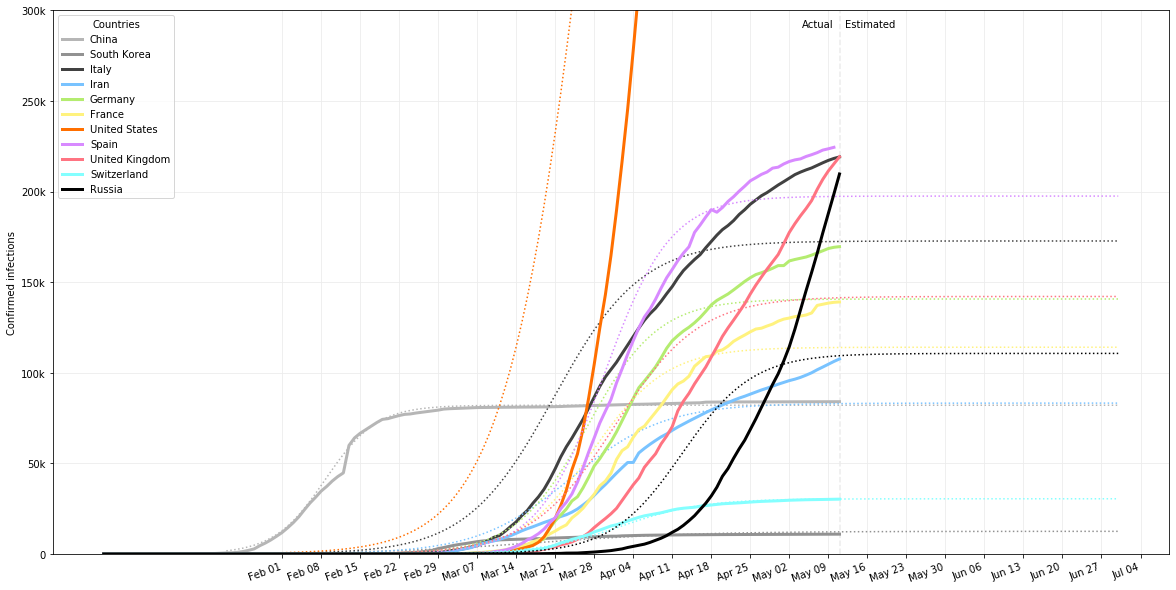

In [86]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for d in dat:
  country_name, color_key, fit = itemgetter('name', 'color', 'fit')(d)
  country = countries[country_name]
  ax.plot(
    country['date'],
    country['count'],
    label=country_name,
    color=colors[color_key],
    linewidth=3
  )
  ax.plot(
    all_dates,
    fit,
    color=colors[color_key],
    linestyle=':'
  )

# plots the "now" line
y_max = 300000
now = np.datetime64('2020-05-11').astype('datetime64[D]')
plt.vlines(now, ymin=0, ymax=y_max, colors=colors['very_light_gray'], linestyles='dashed')
plt.annotate('Actual', xy=(now - np.timedelta64(1, 'D'), y_max - 5000), ha='right', va='top')
plt.annotate('Estimated', xy=(now + np.timedelta64(1, 'D'), y_max - 5000), ha='left', va='top')

ticks = [np.datetime64('2020-02-01') + np.timedelta64(7 * x, 'D') for x in range(0, 23)]
label_from_tick = lambda tick: pd.to_datetime(tick).strftime('%b %d')
tick_labels = list(map(label_from_tick, ticks))
plt.xticks(ticks, tick_labels, rotation=20, horizontalalignment='right')

plt.ylim((0, y_max))
ax.set_yticklabels(['0' if x == 0 else '{:.0f}k'.format(int(x) / 1000) for x in ax.get_yticks().tolist()])
plt.ylabel('Confirmed infections')

plt.grid(color=colors['very_light_gray'])

plt.legend(title='Countries', loc='upper left')

plt.show();

In [4]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
    plt.show();

In [5]:
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [6]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions: one exposed

In [9]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

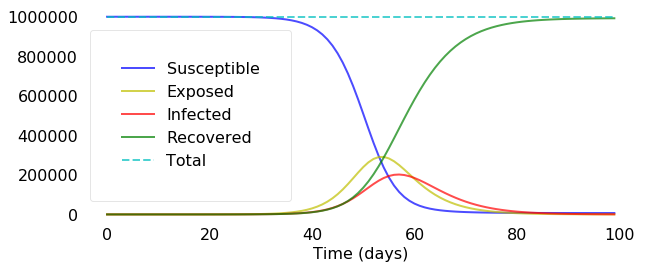

In [12]:
plotseird(t, S, E, I, R)